Raphaël Razafindralambo Computational Statistics HW3

In [110]:
import numpy as np
from numba import jit
import time
from scipy.stats import invgamma
from scipy.stats import norm
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

## $\textbf{Exercise 1:}$

#### $\textit{Question 2:  Generate synthetic data from the model by taking some reasonable values for the parameters.}$

In [70]:
# We create the model
class PopulationModel:
    def __init__(self, N=100, K=20, fixed_params=None, true_theta=None):
        self.fixed_params = fixed_params or {
            #Global parameters
            "p0": 0,
            "sigma_p0": 0,
            "sigma_t0": 0.1,
            "sigma_v0": 0.1,

            #A priori distributions parameters
            "s_t0": 0.1,
            "s_v0": 0.1,
            "mm_t0": 1,
            "mm_v0": 1,
            "m": 5,
            "m_xi": 5,
            "m_tau":5,
            "v": 5,
            "v_xi":5,
            "v_tau":5,
        }

        # theta
        self.true_theta = true_theta or {
            "m_t0": np.random.normal(loc=self.fixed_params["mm_t0"],scale=self.fixed_params["s_t0"]),
            "m_v0": np.random.normal(loc=self.fixed_params["mm_v0"],scale=self.fixed_params["s_v0"]),
            "sigma_xi": np.sqrt(invgamma.rvs(a=self.fixed_params["v_xi"], scale=self.fixed_params["m_xi"])),
            "sigma_tau": np.sqrt(invgamma.rvs(a=self.fixed_params["v_tau"], scale=self.fixed_params["m_tau"])),
            "sigma": np.sqrt(invgamma.rvs(a=self.fixed_params["v"], scale=self.fixed_params["m"])),
        }

        # t0 and v0
        self.fixed_params["t0"] = np.random.normal(loc=self.true_theta["m_t0"], scale=self.fixed_params["sigma_t0"])
        self.fixed_params["v0"] = np.random.normal(loc=self.true_theta["m_v0"], scale=self.fixed_params["sigma_v0"])

    def update_param(self, param_name, new_value):
        if param_name in self.true_theta:
            self.true_theta[param_name] = new_value
        elif param_name in self.fixed_params:
            self.fixed_params[param_name] = new_value
        else:
            print(f"Parameter {param_name} not found.")

    def get_params(self):
        return {**self.fixed_params, **self.true_theta}

    def d(self,t,t0=None,v0=None):
        if t0 is None: t0 = self.fixed_params["t0"]
        if v0 is None: v0 = self.fixed_params["v0"]
        return self.fixed_params["p0"] + v0*(t-t0)

    def di(self,t,alpha,tau,t0=None,v0=None):
        if t0 is None: t0 = self.fixed_params["t0"]
        return self.d(alpha*(t-t0-tau)+t0,t0,v0)

    def generate_data(self,N,K):
        y = np.zeros((N, K))
        for i in range(N):
            alpha = np.exp(np.random.normal(loc=0, scale=self.true_theta["sigma_xi"]))
            tau = np.random.normal(loc=0, scale=self.true_theta["sigma_tau"])
            y[i, :] = np.array([self.di(j, alpha, tau) for j in range(K)]) + np.random.normal(loc=0, scale=self.true_theta["sigma"], size=K)
        return y

    def __getitem__(self, param_name):
        if param_name in self.fixed_params:
            return self.fixed_params[param_name]
        elif param_name in self.true_theta:
            return self.true_theta[param_name]
        else:
            print(f"Parameter '{param_name}' not found.")
            return None
    def __call__(self,N,K):
        return self.generate_data(N,K)



In [71]:
model = PopulationModel(true_theta={"m_t0":0, "m_v0":1, "sigma_xi":0.1, "sigma_tau":0.1, "sigma":0.1})
model.get_params()

{'p0': 0,
 'sigma_p0': 0,
 'sigma_t0': 0.1,
 'sigma_v0': 0.1,
 's_t0': 0.1,
 's_v0': 0.1,
 'mm_t0': 1,
 'mm_v0': 1,
 'm': 5,
 'm_xi': 5,
 'm_tau': 5,
 'v': 5,
 'v_xi': 5,
 'v_tau': 5,
 't0': -0.25102132668430105,
 'v0': 0.9058615557315981,
 'm_t0': 0,
 'm_v0': 1,
 'sigma_xi': 0.1,
 'sigma_tau': 0.1,
 'sigma': 0.1}

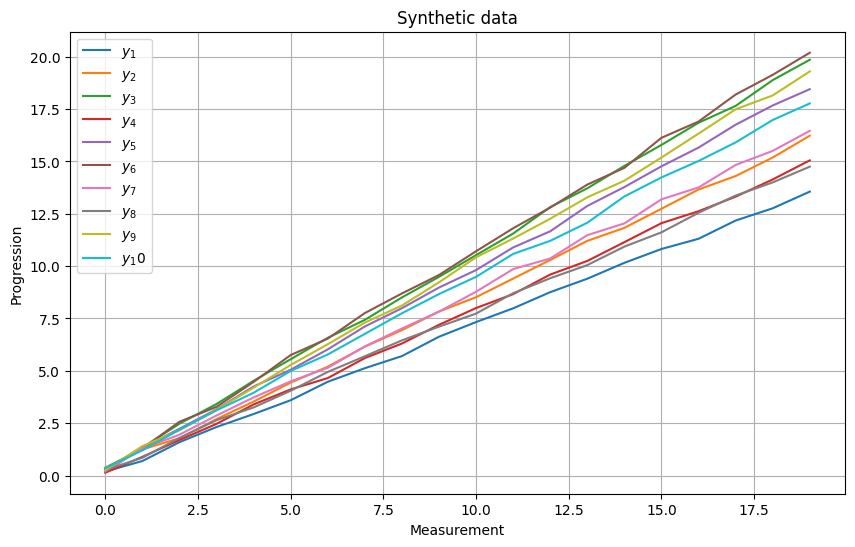

In [72]:
# Generate data
N = 100
K = 20
y = model(N,K)

# Plot
plt.figure(figsize=(10, 6))
for i in range(10):
    plt.plot(y[i, :], label=f'$y_{i+1}$')

plt.title("Synthetic data")
plt.xlabel("Measurement")
plt.ylabel("Progression")
plt.grid()
plt.legend()
plt.show()


#### $\textit{Question 3:  Metropolis Hasting sampler.}$

In [136]:
def log_posterior(z,y,model):
    '''
    Inputs:
    y -> N,K
    Latent variable z -> (2N+2,1)
    t -> (N,K)

    Output:
    Real value

    '''

    N = y.shape[0]

    # z
    t0, v0 = z[0],z[1]
    xi = z[2:N+2]
    alpha = np.exp(xi) # (N, 1)
    tau = z[N+2:]

    dists = np.array([model.di(np.arange(K),alpha[i],tau[i],t0,v0) for i in range(N)])
    # y depends on distance and epsilon
    # distance dists depends only on t,alpha,tau,t0,v0,p0

    log = -0.5*np.sum(((y - dists)/model["sigma"])**2)
    -0.5*((t0-model["m_t0"])/model["sigma_t0"])**2 - 0.5*((v0-model["m_v0"])/model["sigma_v0"])**2
    -0.5*np.sum((xi/model["sigma_xi"])**2) -0.5*np.sum((tau/model["sigma_tau"])**2)
    -0.5*np.sum(xi)

    return log


In [165]:
def HM_sampler(N,K, model, z0, maxIter = 1000, verbose=0):
    '''
    Inputs:
    z0 -> (2N+2,1)
    theta = mt0,mv0,sigmaxi,sigmatau,sigma -> 5 x 1

    Output:
    List of z

    '''
    start = time.time()

    # Initialization
    z = z0.copy() # initial state
    zs = [z0]

    # Proposal distribution
    sigma_prop = 0.05 # optimal for gaussian proposal
    cov_prop = (sigma_prop**2)*np.identity(2*N+2)

    if verbose > 0: its = tqdm(range(maxIter))
    else: its = range(maxIter)

    y = model(N,K)
    acc = 0
    for k in its:

        # Proposal
        z_star = np.random.multivariate_normal(mean = z, cov = cov_prop)

        # Acceptance rejection

        q_prop = log_posterior(z_star,y,model)
        q_prev = log_posterior(z,y,model)
        U = np.random.uniform(low=0,high=1)
        alpha = min(0,q_prop-q_prev) # log acceptation
        if np.log(U) < alpha:
            z = z_star.copy()
            acc += 1
        #print(alpha)


        # Save
        zs.append(z)
    if verbose > 1:
        print("Taux d'acceptation: ", acc/maxIter)
        print(f"Execution time of Symetric Random Walk MH: {time.time() - start} s.")
    return z,zs


In [166]:
z0 = np.random.random(2 * N + 2)

z,zs = HM_sampler(N,K,model,z0, maxIter = 2000,verbose=2)

  0%|          | 0/2000 [00:00<?, ?it/s]

Taux d'acceptation:  0.03
Execution time of Symetric Random Walk MH: 34.9282546043396 s.


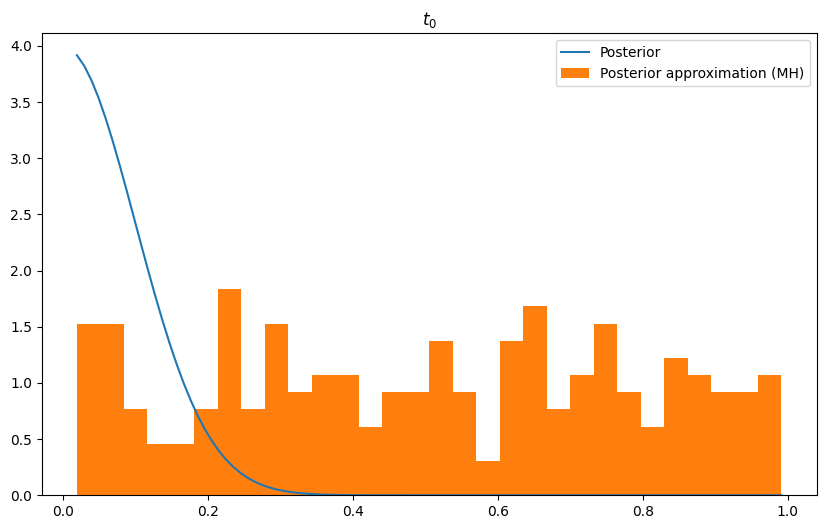

In [167]:
t0s = zs[0]

plt.figure(figsize=(10,6))
xx = np.linspace(min(t0s), max(t0s), 100)
plt.plot(xx, norm.pdf(xx, loc=model["m_t0"], scale=model["sigma_t0"]), label="Posterior")
plt.hist(t0s, bins=30, density=True, label="Posterior approximation (MH)")
plt.title("$t_0$")
plt.legend()
plt.show()

array([-0.53457346,  0.61930416,  0.83862696,  0.59516431, -0.29841201,
       -0.87371238,  0.25352721, -0.56559994,  0.57075115,  0.85851494,
       -0.0236738 , -0.94540557,  0.07635974,  1.02686749, -1.16705476,
       -0.36205952,  0.29085922, -0.10923536, -0.36541876, -0.13439677,
        0.13709579, -0.16194485,  0.88911511,  0.1508251 , -0.22555247,
        0.80538416,  0.12497489, -0.05253581, -0.13941155, -0.62960275,
        0.3662367 ,  0.44706822,  0.32668407,  0.48663195, -0.71768279,
       -0.14752224,  0.99567166,  0.31124417, -0.49553297,  0.23986237,
        0.35805046, -0.18126207, -0.20384493, -0.18718949, -0.40762597,
        0.75461345,  0.22925412,  0.11128705, -0.55069038,  0.23154357,
        0.75514645,  0.02278734, -0.18100258,  0.01336819,  0.31437341,
        0.43683807, -1.67474619,  0.56643203, -0.05247827,  0.01931532,
        0.07098482, -1.02377788,  0.19377815,  0.83402547, -0.03827397,
        0.36897474,  0.56004484, -0.64125897, -0.08416058,  0.32